# Markowitz Theorem

This Notebook applies the Markowitz Theorem to solve a Portfolio Optimization Problem

In [111]:
%%bash
pip install -r ../requirements.txt

  Using cached yahooquery-2.3.7-py3-none-any.whl.metadata (5.0 kB)
  Using cached requests_futures-1.0.2-py2.py3-none-any.whl.metadata (12 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached yahooquery-2.3.7-py3-none-any.whl (52 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/8.6 MB ? eta -:--:--━━━━━━━━━━━━━━━━━ 4.2/8.6 MB 24.1 MB/s eta 0:00:01━━━━━━━━━━━ 8.6/8.6 MB 23.8 MB/s eta 0:00:00
Using cached requests_futures-1.0.2-py2.py3-none-any.whl (7.7 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Attempting uninstall: lxml
    Found existing installation: lxml 5.3.1
    Uninstalling lxml-5.3.1:
      Successfully uninstalled lxml-5.3.1


In [112]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from fredapi import Fred
import matplotlib.pyplot as plt

We define the parameters as the stocks, the end and start date

In [113]:
stocks = ['SPY','BND','GLD','QQQ','VTI']
end_date = datetime.today()
start_date = end_date - timedelta(days = 100*365)

In [114]:
adj_close_df = pd.DataFrame()

for s in stocks:
    data = yf.download(s, start=start_date, end=end_date, auto_adjust=False)
    adj_close_df[s] = data['Adj Close']
data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,VTI,VTI,VTI,VTI,VTI,VTI
Date,,,,,,
2001-06-15,36.467434,55.665001,56.005001,55.174999,55.424999,1067400
2001-06-18,36.234882,55.310001,55.915001,55.310001,55.814999,282600
2001-06-19,36.336411,55.465000,56.165001,55.235001,56.150002,1777600
2001-06-20,36.719662,56.049999,56.075001,55.375000,55.375000,476000
2001-06-21,37.014469,56.500000,56.724998,55.875000,56.000000,240400


In [115]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

In [116]:
# 252 represents the number of trading days

cov_matrix = log_returns.cov() * 252

In [117]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
	p_return = expected_return(weights, log_returns) - risk_free_rate
	return p_return / standard_deviation(weights, cov_matrix)

def negative_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [118]:
cov_matrix = log_returns.cov() * 252

Portofolio optimization

In [119]:
# risk_free_rate = 0.02

fred = Fred(api_key="e9048dc2c26dae67bc75a443cd644ce3")
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_year_treasury_rate.iloc[-1]


In [120]:
constraints = {'type':'eq', 'fun': lambda weights : np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range (len(stocks))]

In [121]:
initial_weights = np.array([1/len(stocks)] * len(stocks))

optimized_results = minimize(negative_sharpe_ratio, initial_weights, 
                            args=(log_returns, cov_matrix, risk_free_rate),
                            method='SLSQP', constraints=constraints, bounds=bounds)

In [122]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(stocks, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.0000
BND: 0.0000
GLD: 0.5000
QQQ: 0.5000
VTI: 0.0000
Expected Annual Return: 0.1100
Expected Volatility: 0.1438
Sharpe Ratio: 0.4557


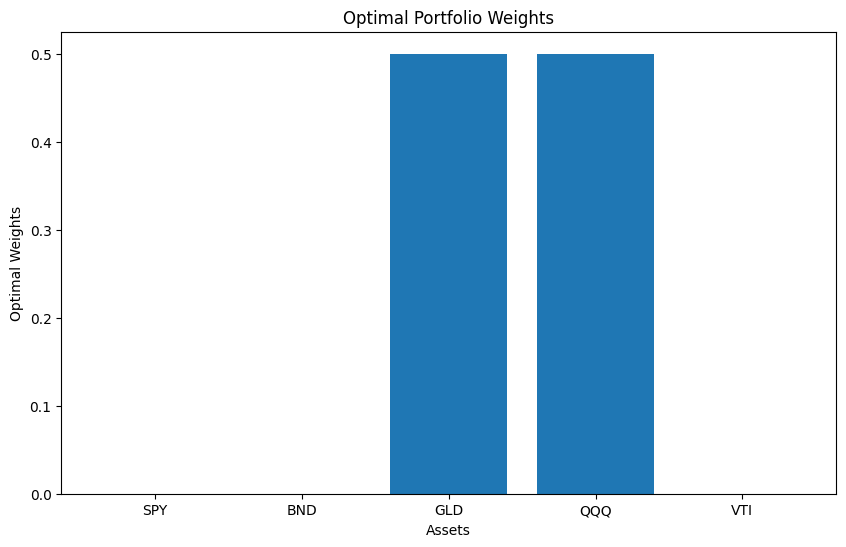

In [123]:
plt.figure(figsize=(10, 6))
plt.bar(stocks, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()